<a href="https://colab.research.google.com/github/neihtfool/Convolutional-Networks/blob/master/Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import tempfile
import time

from six.moves.urllib.request import urlopen
from six import BytesIO
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps


print(tf.__version__)
print("Available GPU devices: %s" % tf.test.gpu_device_name())

     |████████████████████████████████| 515.7MB 31kB/s 
     |████████████████████████████████| 2.8MB 58.0MB/s 
     |████████████████████████████████| 460kB 60.1MB/s 
     |████████████████████████████████| 2.9MB 55.4MB/s 
     |████████████████████████████████| 778kB 45.3MB/s 
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0
2.2.0-dev20200228
Available GPU devices: /device:GPU:0


In [0]:
def display_image(image):
  fig = plt.figure(figsize=(20,15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256, display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

In [0]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin* im_height, ymax * im_height)

  draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)

  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle( [left, text_bottom - text_height - 2 * margin, (left + text_width, text_bottom)], fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

In [0]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
  except IOError:
    print("Font not found.")
    font = ImageFont.load_default()

  for i in range (min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  
  return image

Image downloaded to /tmp/tmpe_fald3p.jpg.


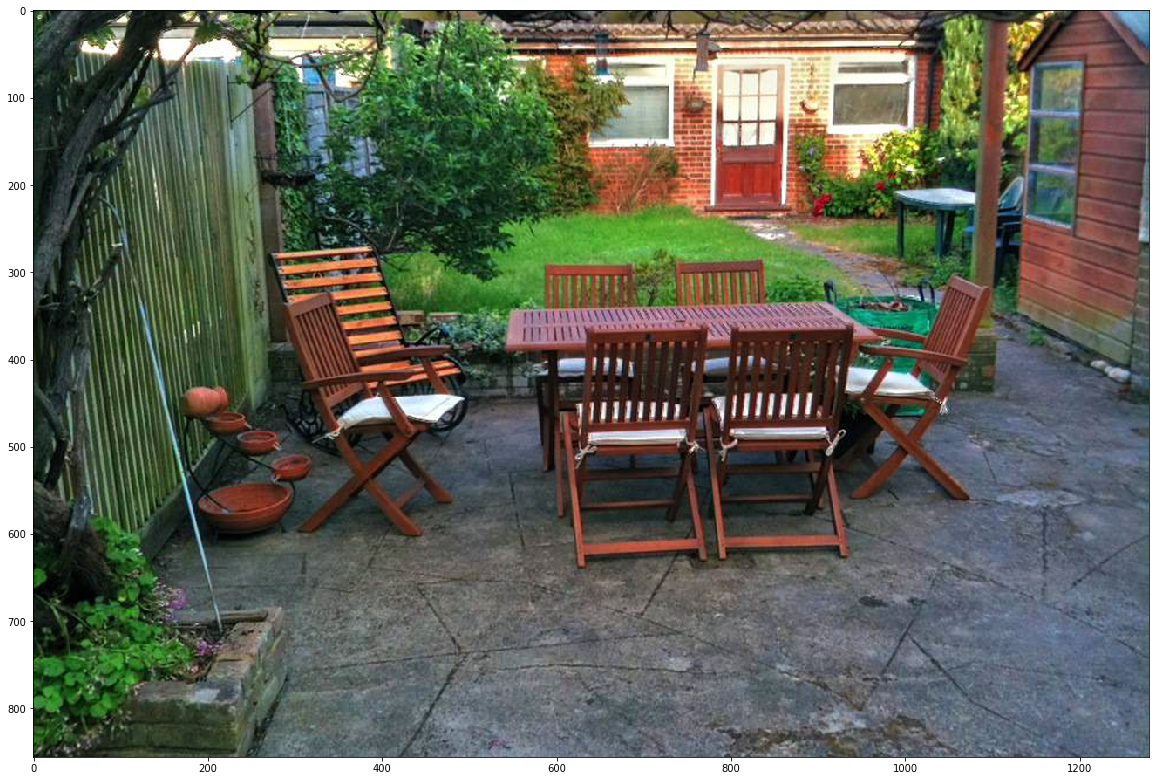

In [15]:
image_url = "https://farm1.staticflickr.com/4032/4653948754_c0d768086b_o.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [29]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [0]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()


  result = {key: value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result['detection_scores']))
  print("Inference time: ", end_time - start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"]
  )

  display_image(image_with_boxes)

Found 100 objects.
Inference time:  1.4585070610046387


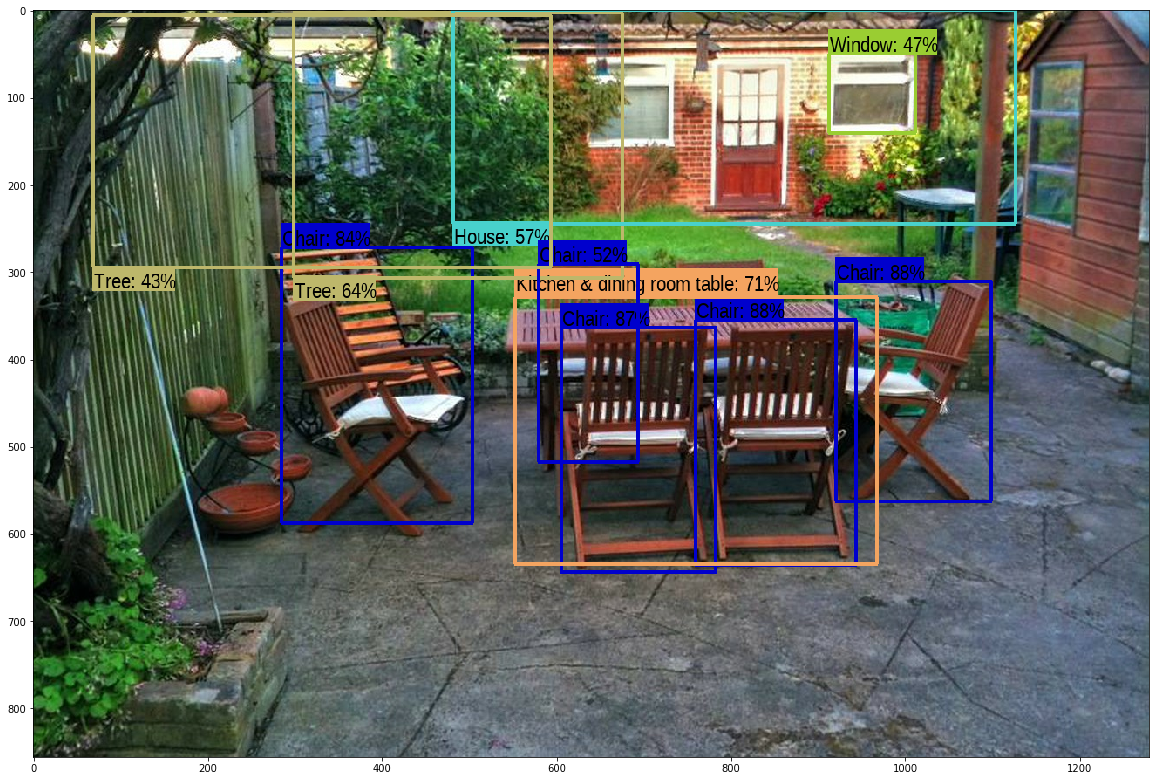

In [52]:
run_detector(detector, downloaded_image_path)

More Images

Image downloaded to /tmp/tmpugifotw0.jpg.
Found 100 objects.
Inference time:  3.1578691005706787
Inference time: 3.447782278060913
Image downloaded to /tmp/tmpxqy3izcj.jpg.
Found 100 objects.
Inference time:  1.362595558166504
Inference time: 1.6492908000946045
Image downloaded to /tmp/tmpm31lq6lk.jpg.
Found 100 objects.
Inference time:  1.3544816970825195
Inference time: 1.7135612964630127


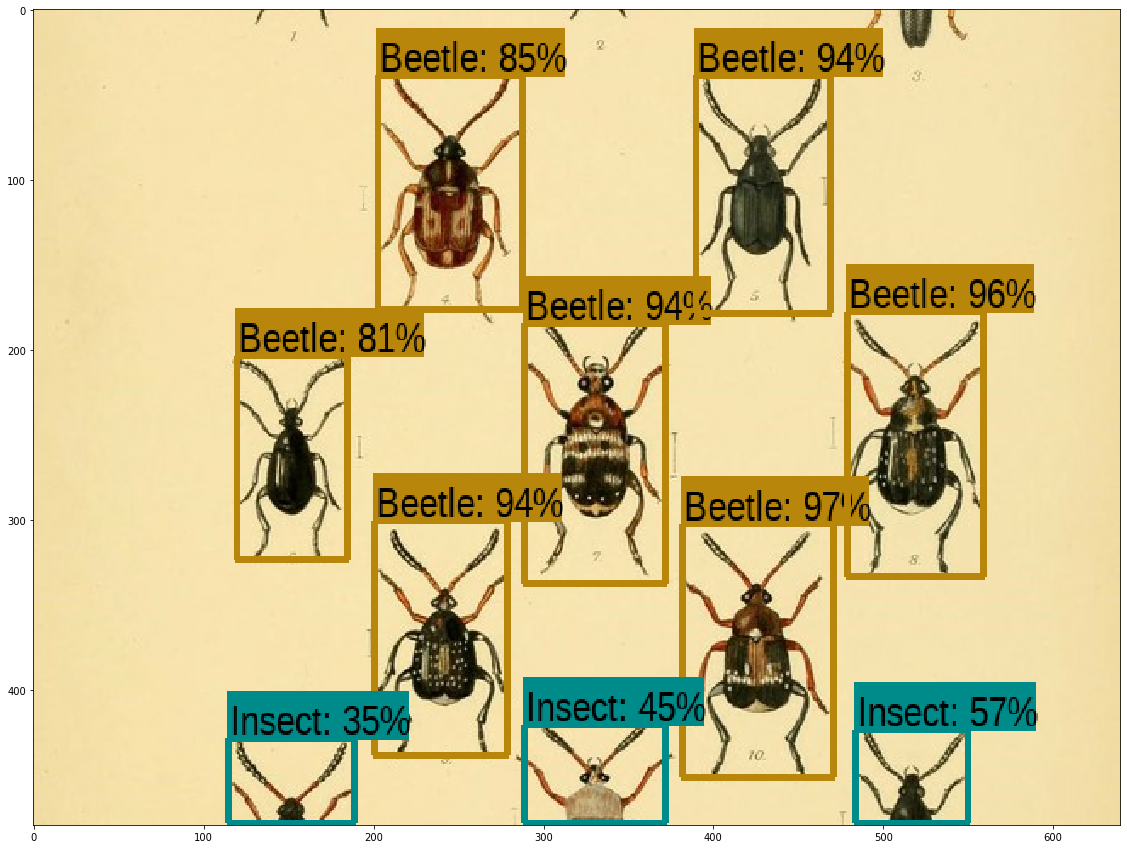

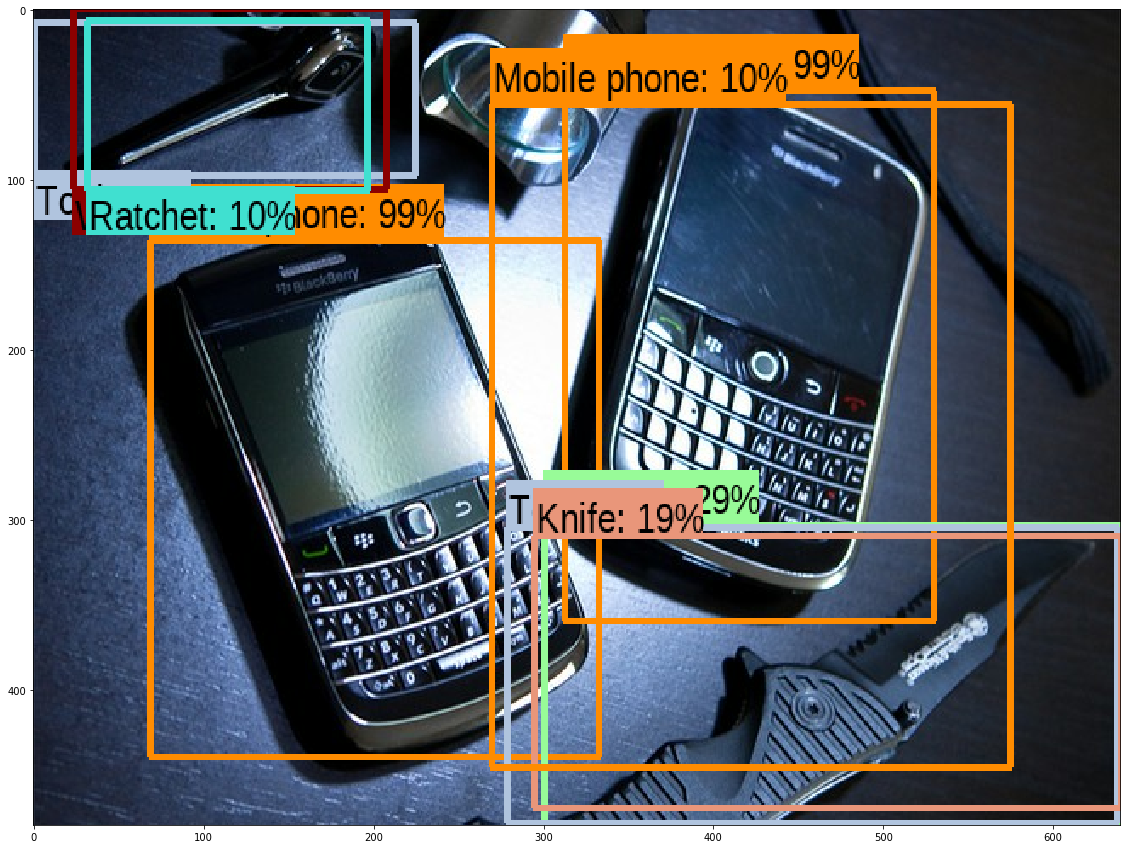

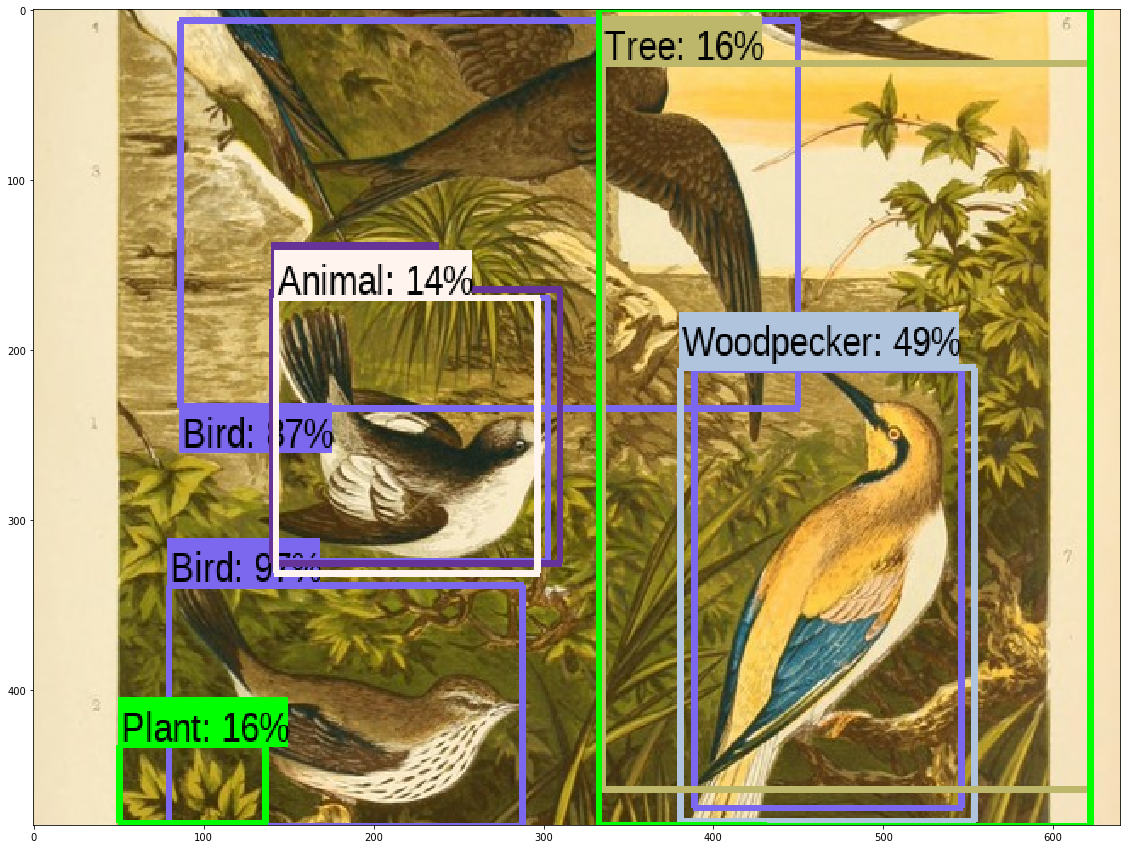

In [53]:
image_urls = ["https://farm7.staticflickr.com/8092/8592917784_4759d3088b_o.jpg",
              "https://farm6.staticflickr.com/2598/4138342721_06f6e177f3_o.jpg",
              "https://c4.staticflickr.com/9/8322/8053836633_6dc507f090_o.jpg"]
          
for image_url in image_urls:
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 640, 480)
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:",  end_time - start_time)